In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from scipy import constants
import scipy

In [32]:
(0.65-0.760j)**3.63

(-1.000149675444644-0.007979626875152183j)

In [87]:
import scipy 

def generate_gaussian_pulse(duration, sigma, ramp_time, num_points):
    """
    Generates a pulse with Gaussian ramp-up, hold, and Gaussian ramp-down.

    Parameters:
        duration (float): Total duration of the pulse.
        sigma (float): Standard deviation of the Gaussian used for the ramps.
        ramp_time (float): Duration of the ramp, typically ramp_time = 3 * sigma.

    Returns:
        np.ndarray: The generated pulse.
        np.ndarray: The corresponding time array.
    """
    if ramp_time > duration:
        raise ValueError("Ramp time must be less than or equal to the total duration.")
    
    ramp_points = int(ramp_time / (duration / num_points))  # Calculate number of points for the ramp
    hold_points = int((duration - 2 * ramp_time) / (duration / num_points))  # Hold points

    # Create time arrays for ramps and hold
    t_ramp = np.linspace(0, ramp_time, ramp_points)
    t_hold = np.linspace(ramp_time, duration - ramp_time, hold_points)

    # Create Gaussian ramps
    ramp_up = np.exp(-0.5 * ((t_ramp - ramp_time) / sigma) ** 2)
    ramp_down = np.exp(-0.5 * ((t_ramp) / sigma) ** 2)

    # Hold section
    hold = np.ones_like(t_hold)

    # Concatenate the segments
    pulse = np.concatenate([ramp_up, hold, ramp_down])
    time = np.concatenate([t_ramp, t_hold, t_ramp + (duration - ramp_time)])
    
    # Rescale pulse to start at 0 with maximum amp = 1
    pulse_start = pulse[0]
    pulse -= pulse_start
    pulse_max = np.max(pulse)
    pulse /= pulse_max

    return time, pulse

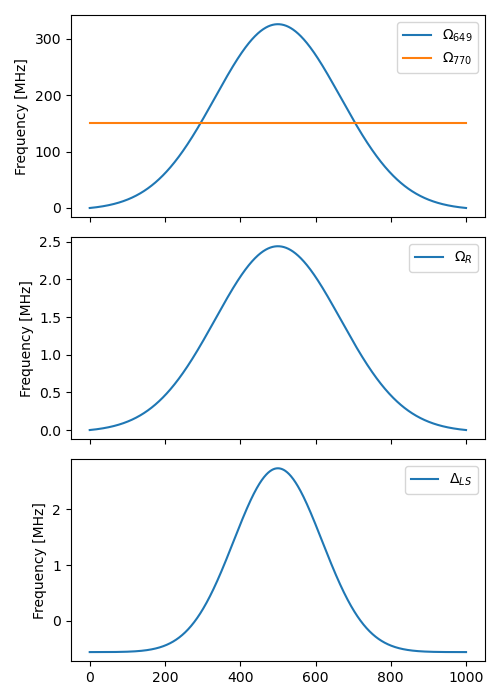

In [127]:
gate_time = 1e-6
Omega_770 = 2 * np.pi * 150 * 1e6
detuning = 2 * np.pi * 10 * 1e9  # Hz
num_steps = 1000 
freq_scale = 1e9

# Gaussian ramp
sigma = gate_time * freq_scale / 3 / 2
ramp_time = 3 * sigma
hold_time = 0
duration = ramp_time * 2 + hold_time

time, pulse = generate_gaussian_pulse(duration, sigma, ramp_time, num_steps)
integral = scipy.integrate.simpson(
    Omega_770 * pulse / (2 * detuning), 
    x = time * 1e-9
)
integral /= (2 * np.pi)

def Omega_649_arr(t):
    return np.interp(t, time, pulse) / integral

def Omega_Raman_arr(t):
    return Omega_649_arr(t) * Omega_770 / (2 * detuning)

def detuning_arr(t, ratio):
    return Omega_Raman_arr(t) * ratio 

def light_shift_arr(t):
    shift_649 = Omega_649_arr(t)**2 / (4 * detuning) + (Omega_649_arr(t) * 0.660000 / 0.933)**2 / (4 * (detuning + 2 * np.pi * 10.22 * 1e9))
    shift_770 = Omega_770**2 / (4 * detuning)
    return (shift_649 - shift_770) / freq_scale

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 7), sharex=True)

ax[0].plot(time, Omega_649_arr(time) / 2 / np.pi / 1e6, label=r'$\Omega_{649}$')
ax[0].plot(time, Omega_770 * np.ones_like(Omega_649_arr(time)) / 2 / np.pi / 1e6, label=r'$\Omega_{770}$')
ax[0].set_ylabel('Frequency [MHz]')
ax[0].legend()

ax[1].plot(time, Omega_Raman_arr(time) / 2 / np.pi / 1e6, label=r'$\Omega_R$')
ax[1].set_ylabel('Frequency [MHz]')
ax[1].legend()

ax[2].plot(time, light_shift_arr(time) / 2 / np.pi * 1e3, label=r'$\Delta_{LS}$')
ax[2].set_ylabel('Frequency [MHz]')
ax[2].legend()


fig.tight_layout()


In [140]:


ratio = 0.1

def spherical_cap_area(Delta_over_Omega):
    if Delta_over_Omega == 0:
        theta = np.pi / 2
    else:
        theta = np.arctan(1 / Delta_over_Omega)
    return 2 * np.pi * (1 - np.cos(theta))

spherical_cap_area(0.1)

# phase_0 = spherical_cap_area(Omega, Delta + 2 * np.pi * 10.22 * 1e9)
# phase_1 = 

5.657985001817119

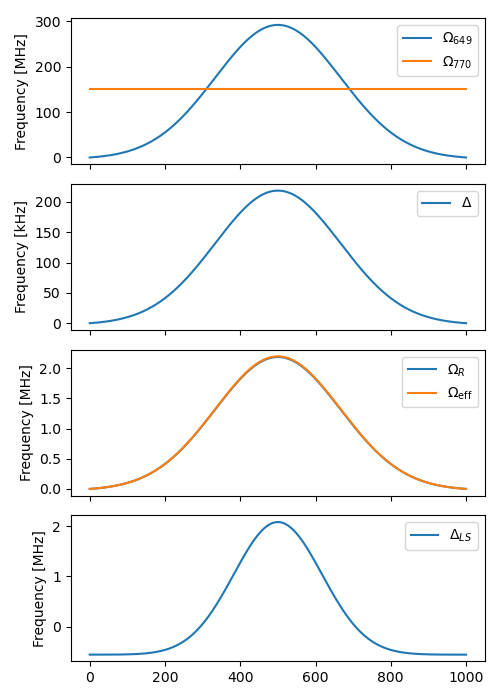

In [168]:
gate_time = 1e-6
Omega_770 = 2 * np.pi * 150 * 1e6
detuning = 2 * np.pi * 10 * 1e9  # Hz
Delta_over_Omega = 0.1
num_steps = 1000 
freq_scale = 1e9

# Gaussian ramp
sigma = gate_time * freq_scale / 3 / 2
ramp_time = 3 * sigma
hold_time = 0
duration = ramp_time * 2 + hold_time

time, pulse = generate_gaussian_pulse(duration, sigma, ramp_time, num_steps)
integral = np.sqrt(1 + Delta_over_Omega**2) * scipy.integrate.simpson(
    (Omega_770 * pulse / (2 * detuning)), 
    x = time * 1e-9
)
area = spherical_cap_area(Delta_over_Omega)
integral /= area


def Omega_649_arr(t):
    return np.interp(t, time, pulse) / integral

def Omega_Raman_arr(t):
    return Omega_649_arr(t) * Omega_770 / (2 * detuning)

def detuning_arr(t):
    return Omega_Raman_arr(t) * Delta_over_Omega 

def Omega_eff_arr(t):
    return np.sqrt(Omega_Raman_arr(t)**2 + detuning_arr(t)**2)

def light_shift_arr(t):
    shift_649 = Omega_649_arr(t)**2 / (4 * detuning) + (Omega_649_arr(t) * 0.660000 / 0.933)**2 / (4 * (detuning + 2 * np.pi * 10.22 * 1e9))
    shift_770 = Omega_770**2 / (4 * detuning)
    return (shift_649 - shift_770) / freq_scale

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5, 7), sharex=True)

ax[0].plot(time, Omega_649_arr(time) / 2 / np.pi / 1e6, label=r'$\Omega_{649}$')
ax[0].plot(time, Omega_770 * np.ones_like(Omega_649_arr(time)) / 2 / np.pi / 1e6, label=r'$\Omega_{770}$')
ax[0].set_ylabel('Frequency [MHz]')
ax[0].legend()

ax[1].plot(time, detuning_arr(time) / 2 / np.pi / 1e3, label=r'$\Delta$')
ax[1].set_ylabel('Frequency [kHz]')
ax[1].legend()

ax[2].plot(time, Omega_Raman_arr(time) / 2 / np.pi / 1e6, label=r'$\Omega_R$')
ax[2].plot(time, Omega_eff_arr(time) / 2 / np.pi / 1e6, label=r'$\Omega_\text{eff}$')
ax[2].set_ylabel('Frequency [MHz]')
ax[2].legend()

ax[3].plot(time, light_shift_arr(time) / 2 / np.pi * 1e3, label=r'$\Delta_{LS}$')
ax[3].set_ylabel('Frequency [MHz]')
ax[3].legend()


fig.tight_layout()


In [81]:
def simulate_raman_gate(
    Omega_649: float,
    Omega_770: float,
    detuning: float,  # Hz
    detuning_offset: float,  # Hz
    initial_states: list[str],  # ['00', '01', '10', '11'] or any subset
    num_steps: int,
    gate_time: float = None
):
    
    
    freq_scale = 1e9  # GHz
    
    # =========================
    # Initialize energy levels 
    # =========================
    # NOTE: hard-coded for 5G magnetic field
    
    levels = [
        # 3P0 sublevels
        {'level': '3P0', 'F': 1/2, 'mF': 1/2,  'energy_Hz': 0},
        {'level': '3P0', 'F': 1/2, 'mF': -1/2, 'energy_Hz': 3749.528976851414},
        # 3S1 sublevels
        {'level': '3S1', 'F': 1/2, 'mF': 1/2,  'energy_Hz': 461850274160685.7},
        {'level': '3S1', 'F': 1/2, 'mF': -1/2, 'energy_Hz': 461850292913971.44},
        {'level': '3S1', 'F': 3/2, 'mF': 3/2,  'energy_Hz': 461860484233885.6},
        {'level': '3S1', 'F': 3/2, 'mF': 1/2,  'energy_Hz': 461860493612403.4},
        {'level': '3S1', 'F': 3/2, 'mF': -1/2, 'energy_Hz': 461860502990920.8},
        {'level': '3S1', 'F': 3/2, 'mF': -3/2, 'energy_Hz': 461860512369438.56},
        # 3P2 sublevels
        {'level': '3P2', 'F': 3/2, 'mF': 3/2,  'energy_Hz': 72602523903671.75},
        {'level': '3P2', 'F': 3/2, 'mF': 1/2,  'energy_Hz': 72602536499251.66},
        {'level': '3P2', 'F': 3/2, 'mF': -1/2, 'energy_Hz': 72602549094831.69},
        {'level': '3P2', 'F': 3/2, 'mF': -3/2, 'energy_Hz': 72602561690411.6},
        {'level': '3P2', 'F': 5/2, 'mF': 5/2,  'energy_Hz': 72609214146883.69},
        {'level': '3P2', 'F': 5/2, 'mF': 3/2,  'energy_Hz': 72609222545186.78},
        {'level': '3P2', 'F': 5/2, 'mF': 1/2,  'energy_Hz': 72609230943489.86},
        {'level': '3P2', 'F': 5/2, 'mF': -1/2, 'energy_Hz': 72609239341793.05},
        {'level': '3P2', 'F': 5/2, 'mF': -3/2, 'energy_Hz': 72609247740096.14},
        {'level': '3P2', 'F': 5/2, 'mF': -5/2, 'energy_Hz': 72609256138399.22},
    ]

    N = len(levels)
    basis_states = []
    for i, level in enumerate(levels):
        new_row = level.copy()
        new_row['basis'] = basis(N, i)
        basis_states.append(new_row)
    basis_states = pd.DataFrame(basis_states)
    
    # set intermediate and excited states for Raman gate
    reference_state_3s1 = basis_states[(basis_states['level'] == '3S1') & \
                                       (basis_states['F'] == 3/2) & \
                                       (basis_states['mF'] == 1/2)]
    reference_state_3p2 = basis_states[(basis_states['level'] == '3P2') & \
                                       (basis_states['F'] == 5/2) & \
                                       (basis_states['mF'] == 1/2)]
        
    # ==============================
    # matrix elements [atomic units]
    # ==============================
    
    # level1 = 3P0 -> level2 = 3S1
    matrix_elements_649 = [
        {'F1': 1/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 0.660000},
        {'F1': 1/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.660000},
        {'F1': 1/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.933381},
        {'F1': 1/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': -0.933381},
    ]
    # level1 = 3P2 -> level2 = 3S1 
    matrix_elements_770 = [
        {'F1': 3/2, 'F2': 1/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 1/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.683333},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': -0.714178},
        {'F1': 3/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': -0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 0.238059},
        {'F1': 3/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 0.714178},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 3/2, 'mF2': 3/2, 'matrix_element': 1.428356},
        {'F1': 5/2, 'F2': 3/2, 'mF1': 1/2, 'mF2': 1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -1/2, 'mF2': -1/2, 'matrix_element': 1.749371},
        {'F1': 5/2, 'F2': 3/2, 'mF1': -3/2, 'mF2': -3/2, 'matrix_element': 1.428356},
    ]
    
    reference_matrix_element_649 = -0.933381
    reference_matrix_element_770 = 1.749371
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_649 = []
    for row in matrix_elements_649:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element']
        new_row['rabi_frequency'] = Omega_649 * matrix_element / reference_matrix_element_649
        rabi_frequencies_649.append(new_row)
    # compute Rabi frequencies [Hz] for each transition
    rabi_frequencies_770 = []
    for row in matrix_elements_770:
        # copy row and remove matrix element
        new_row = row.copy()
        new_row.pop('matrix_element')
        # compute rabi frequency
        matrix_element = row['matrix_element']
        new_row['rabi_frequency'] = Omega_770 * matrix_element / reference_matrix_element_770
        rabi_frequencies_770.append(new_row)
        
    # =====================
    # Construct Hamiltonian
    # =====================
    
    # Initialize Hamiltonian
    H0 = 0
    H1 = 0
    H2 = 0

    # 3P0 -> 3S1
    for transition in rabi_frequencies_649:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P0') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H1 += coupling_term
        
    # 3S1 -> 3P2
    for transition in rabi_frequencies_770:
        Omega = transition['rabi_frequency'] / freq_scale
        state1 = basis_states[(basis_states['level'] == '3P2') & \
                            (basis_states['F'] == transition['F1']) & \
                            (basis_states['mF'] == transition['mF1'])]
        state2 = basis_states[(basis_states['level'] == '3S1') & \
                            (basis_states['F'] == transition['F2']) & \
                            (basis_states['mF'] == transition['mF2'])]
        # add coupling term
        basis1 = state1['basis'].values[0]
        basis2 = state2['basis'].values[0]
        coupling_term = (Omega / 2) * (basis1 * basis2.dag() + basis2 * basis1.dag())
        H0 += coupling_term
        
    # add detunings
    for state in basis_states.to_records():
        if state['level'] in ['3P0', '3P2']:
            H0 += (detuning / freq_scale) * state['basis'] * state['basis'].dag()
        if state['level'] == '3S1':
            ref_detuning = (state['energy_Hz'] - reference_state_3s1['energy_Hz'].values[0]) / freq_scale
            H0 += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
        if state['level'] == '3P2':
            ref_detuning = (state['energy_Hz'] - reference_state_3p2['energy_Hz'].values[0]) / freq_scale
            H0 += 2 * np.pi * ref_detuning * state['basis'] * state['basis'].dag()
            # add light shift compensation for resonance
            H0 += detuning_offset / freq_scale * state['basis'] * state['basis'].dag()
            
    for state in basis_states.to_records():
        if state['level'] == '3P2':
            H2 += state['basis'] * state['basis'].dag()
            
    # Gaussian ramp
    sigma = gate_time * freq_scale / 3 / 2
    ramp_time = 3 * sigma
    hold_time = 0
    duration = ramp_time * 2 + hold_time

    time, pulse = generate_gaussian_pulse(duration, sigma, ramp_time, num_steps)
    integral = scipy.integrate.simpson(
        np.sqrt((Omega_649 * Omega_770 * pulse / (2 * detuning))**2 + detuning_offset**2), 
        x = time * 1e-9
    )
    integral /= (2 * np.pi)

    def H1_coefficient(t):
        return np.interp(t, time, pulse) / integral

    def H2_coefficient(t):
        Omega_649_ramp = H1_coefficient(t) * Omega_649
        shift_649 = Omega_649_ramp**2 / (4 * detuning) + (Omega_649_ramp * 0.660000 / 0.933)**2 / (4 * (detuning + 2 * np.pi * 10.22 * 1e9))
        shift_770 = Omega_770**2 / (4 * detuning)
        return (shift_649 - shift_770) / freq_scale

            
    # =======================
    # Simulate time evolution
    # =======================

    # calculate gate time
    gi_rabi_freq = [transition['rabi_frequency'] for transition in rabi_frequencies_649 \
        if transition['F1'] == 1/2 and transition['mF1'] == 1/2 and \
        transition['F2'] == reference_state_3s1['F'].values[0] and \
        transition['mF2'] == reference_state_3s1['mF'].values[0]][0]
    ie_rabi_freq = [transition['rabi_frequency'] for transition in rabi_frequencies_770 \
        if transition['F1'] == reference_state_3p2['F'].values[0] and \
        transition['mF1'] == reference_state_3p2['mF'].values[0] and \
        transition['F2'] == reference_state_3s1['F'].values[0] and \
        transition['mF2'] == reference_state_3s1['mF'].values[0]][0]
    
    # Delta_avg = (detuning + (detuning + Delta_LS)) / 2
    raman_rabi_freq = (gi_rabi_freq * ie_rabi_freq) / (2 * detuning) / freq_scale
    print(f'Raman Rabi frequency: {np.abs(raman_rabi_freq) * freq_scale / 1e6 / 2 / np.pi} MHz')
    raman_gate_time = np.abs(2 * np.pi / raman_rabi_freq)
    
    qubit_basis_0 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == -1/2)]['basis'].values[0]
    qubit_basis_1 = basis_states[(basis_states['level'] == '3P0') & \
                                 (basis_states['F'] == 1/2) & \
                                 (basis_states['mF'] == 1/2)]['basis'].values[0]

    rho_inital_dict = {
        '00': qubit_basis_0 * qubit_basis_0.dag(), 
        '01': qubit_basis_0 * qubit_basis_1.dag(), 
        '10': qubit_basis_1 * qubit_basis_0.dag(), 
        '11': qubit_basis_1 * qubit_basis_1.dag()
    }
    
    # Time vector
    t_max = gate_time * freq_scale
    t_list = np.linspace(0, t_max, num_steps)

    # Expectation operators
    e_ops = [state['basis'] * state['basis'].dag() for state in basis_states.to_records()]

    # Solve for the time evolution
    result_dict = {}
    for state in initial_states:
        result = mesolve(
            [H0, [H1, H1_coefficient], [H2, H2_coefficient]],
            rho_inital_dict[state], 
            time, 
            e_ops=e_ops, 
            options=dict(store_states=True))
        result_dict[state] = result
        
    # Construct return value
    output = {
        'basis_states': basis_states,
        't_list': t_list,
        'results': result_dict
    }
        
    return output

In [82]:
Omega_649 = 2 * np.pi * 141.4213562373095 * 1e6
Omega_770 = 2 * np.pi * 141.4213562373095 * 1e6
Delta = 2 * np.pi * 10 * 1e9  # Hz
initial_states = ['00', '01', '10', '11']
num_steps = 1000
detuning_offset = 2 * np.pi * 0 * 1e6

Omega_Raman = Omega_649 * Omega_770 / (2 * Delta)
Omega_eff = np.sqrt(Omega_Raman**2 + detuning_offset**2)
print(f"Omega_Raman = {Omega_Raman / 2 / np.pi / 1e6} MHz")
print(f"Omega_eff = {Omega_eff / 2 / np.pi / 1e6} MHz")
gate_time = 2 * np.pi / Omega_eff 
print(f"gate_time = {gate_time / 1e-9} ns")

output = simulate_raman_gate(
    Omega_649=Omega_649,
    Omega_770=Omega_770,
    detuning=Delta,
    detuning_offset=detuning_offset,
    initial_states=initial_states,
    num_steps=num_steps,
    gate_time=gate_time)

Omega_Raman = 1.0000000000000002 MHz
Omega_eff = 1.0000000000000002 MHz
gate_time = 999.9999999999999 ns
Raman Rabi frequency: 1.0000000000000002 MHz


Text(0.5, 0, 'Time [ns]')

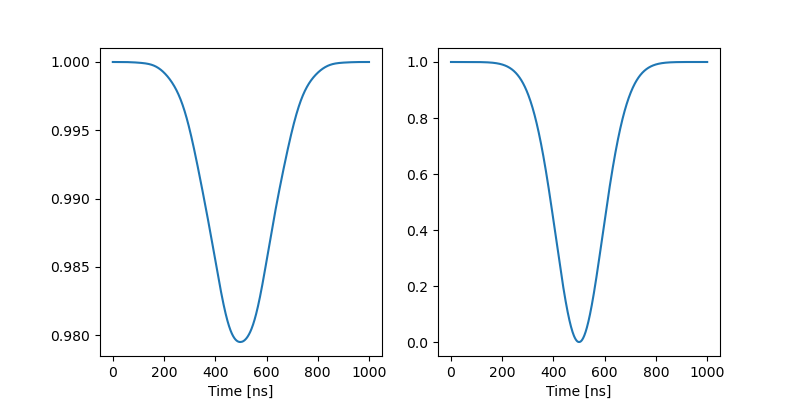

In [83]:
%matplotlib widget

basis_states = output['basis_states']
results = output['results']

ground_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == -0.5][0]
ground_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P0' and state['F'] == 0.5 and state['mF'] == 0.5][0]

intermediate_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == -0.5][0]
intermediate_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3S1' and state['F'] == 1.5 and state['mF'] == 0.5][0]

excited_0_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == -0.5][0]
excited_1_idx = [i for i, state in enumerate(basis_states.to_records()) \
    if state['level'] == '3P2' and state['F'] == 2.5 and state['mF'] == 0.5][0]


ts = output['t_list']
ys_0 = results['00'].expect[ground_0_idx]
ys_1 = results['11'].expect[ground_1_idx]

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))

ax[0].plot(ts, ys_0)
ax[1].plot(ts, ys_1)


ax[0].set_xlabel('Time [ns]')
ax[1].set_xlabel('Time [ns]')

In [84]:
def calculate_fidelity(actual_superop: Qobj, ideal_superop: Qobj):
    vec = np.array(actual_superop[:,:]) @ np.array([1, 0, 0, 1])
    arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
    leakage = 1 - (arr.tr() / 2)
    process_fidelity = 1/4 * Qobj(ideal_superop.dag()[:,:] @ actual_superop[:,:]).tr()
    return np.real((2 * process_fidelity + 1 - leakage) / 3)

rho_final = {state: result.states[-1] for state, result in results.items()}
subspace_vector_final = {state: operator_to_vector(Qobj(rho[:2,:2]))[::-1,:] for state, rho in rho_final.items()}

super_op_sim = Qobj(np.column_stack((
    subspace_vector_final['00'], 
    subspace_vector_final['10'], 
    subspace_vector_final['01'], 
    subspace_vector_final['11'])))

ideal_gate = Qobj(np.array([
    [1, 0, 0, 0],
    [0,-1, 0, 0],
    [0, 0,-1, 0],
    [0, 0, 0, 1]
]))

vec = np.array(super_op_sim[:,:]) @ np.array([1, 0, 0, 1])
arr = Qobj(np.array([[vec[0], vec[1]], [vec[2], vec[3]]]))
leakage = 1 - (arr.tr() / 2)
leakage

# fidelity = calculate_fidelity(super_op_sim, ideal_gate)
# fidelity
# super_op_sim

1.3376752184823815e-06

In [5]:

import numpy as np
np.sqrt(300 * 600)

424.26406871192853